# Accessibility analysis: Calculating travel time matrices in Python


When trying to understand the accessibility of a specific location, you typically want to look at travel times between multiple locations (one-to-many). Next, we will learn how to calculate travel time matrices using `r5py` Python library. **R5py** is a Python library for routing and calculating travel time matrices on multimodal transport networks (walk, bike, public transport and car). It provides a simple and friendly interface to [R5](https://github.com/conveyal/r5) (the Rapid Realistic Routing on Real-world and Reimagined networks) which is a routing engine developed by [Conveyal](https://conveyal.com/). R5py is designed to interact with [geopandas](https://geopandas.org/) GeoDataFrames, and it is inspired by [r5r](https://ipeagit.github.io/r5r) which is a similar wrapper developed for R. R5py exposes some of R5’s functionality via its Python API, in a syntax similar to r5r’s.

### Tutorial objectives

This tutorial focuses on introducing you how to compute travel time matrices by different travel modes using a new Python library called `r5py`. Travel time data is fundamental information whenever aiming to analyze e.g. accessibility -related questions.

### Library status

`r5py` is still a work in progress but it already has core functionalities available to compute travel time matrices that are relevant to spatial accessibility analysis. `r5py` is still missing many of the functionalities of `r5r`, but eventually, both of these libraries aim to provide a similar set of functionalities.


## Data requirements 

When calculating travel times with `r5py`, you typically need a couple of datasets:

- **A road network dataset from OpenStreetMap** (OSM) in Protocolbuffer Binary (`.pbf`) format:
  - This data is used for finding the fastest routes and calculating the travel times based on walking, cycling and driving. In addition, this data is used for walking/cycling legs between stops when routing with transit.
  - *Hint*: Sometimes you might need modify the OSM data beforehand, e.g., by cropping the data or adding special costs for travelling (e.g., for considering slope when cycling/walking). When doing this, you should follow the instructions on the [Conveyal website](https://docs.conveyal.com/prepare-inputs#preparing-the-osm-data). For adding customized costs for pedestrian and cycling analyses, see [this repository](https://github.com/RSGInc/ladot_analysis_dataprep).

- **A transit schedule dataset** in General Transit Feed Specification (GTFS.zip) format (optional):
   - This data contains all the necessary information for calculating travel times based on public transport, such as stops, routes, trips and the schedules when the vehicles are passing a specific stop. You can read about the [GTFS standard here](https://developers.google.com/transit/gtfs/reference).
   - *Hint*: `r5py` can also combine multiple GTFS files, as sometimes you might have different GTFS feeds representing, e.g., the bus and metro connections.

### Sample datasets

In the following tutorial, we use open source datasets for Helsinki Region:
- The population dataset for this tutorial has been obtained from [Helsinki Region Environmental Services HSY](https://www.hsy.fi/en/environmental-information/open-data/avoin-data---sivut/population-grid-of-helsinki-metropolitan-area/) licensed under a Creative Commons Attribution 4.0 International License.
- The street network is a cropped and filtered extract of OpenStreetMap (© OpenStreetMap contributors, [ODbL license](https://www.openstreetmap.org/copyright))
- The GTFS transport schedule dataset for Helsinki Region are open datasets obtained from TransitFeeds:
  - https://transitfeeds.com/p/helsinki-regional-transport/735/latest

## Download the datasets

We have prepared a Zip-package with all relevant data that helps you to start working with the tools quickly. You can download and extract the data by executing the following commands:

In [33]:
# Download the data from a S3 bucket into 'data' folder
!wget -P data/ https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/Sustainability-GIS/Helsinki.zip
    
# Extract the contents
!unzip -q data/Helsinki.zip -d data/

--2023-01-19 09:34:37--  https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/Sustainability-GIS/Helsinki.zip
Resolving a3s.fi (a3s.fi)... 86.50.254.18, 86.50.254.19
Connecting to a3s.fi (a3s.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73671521 (70M) [application/zip]
Saving to: ‘data/Helsinki.zip’

Helsinki.zip        100%[===================>]  70,26M  43,4MB/s    in 1,6s    

2023-01-19 09:34:39 (43,4 MB/s) - ‘data/Helsinki.zip’ saved [73671521/73671521]



If running the cell above does not work for some reason (on your local computer), you can [manually download the data](https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/Sustainability-GIS/Helsinki.zip). If you do this, extract the contents of the Zip file (`Helsinki.zip`) into the `<YOUR_FOLDER_CONTAINING_THIS_NOTEBOOK>/data` -folder. 

### Load the origin and destination data

Let's start by downloading a sample population grid dataset into a geopandas `GeoDataFrame` that we can use as our origin and destination locations. The data also contains the number of residents fo each 250 meter cell:

In [7]:
import geopandas as gpd
import contextily as cx

# Load population points
pop_fp = "data/population_grid_hsy.geojson"
pop_grid = gpd.read_file(pop_fp)

# Convert the polygons to Points
pop_points = pop_grid.copy()
pop_points["geometry"] = pop_points.centroid

# Explore the map
pop_points.explore("ASUKKAITA")

/tmp/ipykernel_541463/1813295200.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pop_points["geometry"] = pop_points.centroid


Let's also check how the attribute table of the data looks like:

In [8]:
# Check the first 5 rows
pop_points.head()

ASUKKAITA                   geometry
0          5  POINT (24.50512 60.28675)
1          8  POINT (24.50535 60.27105)
2          5  POINT (24.50539 60.26880)
3         12  POINT (24.50552 60.25983)
4          5  POINT (24.50906 60.32491)

As we can see the `pop_points` includes information about the number of inhabitants per grid cell (*ASUKKAITA* column). One additional preparation step that we need to do for this data is to add an `id` column for the data which is required by the `r5py` tool to work. For this, we can use the index value of the GeoDataFrame for representing the unique id-values for each location.

In [12]:
# Add a unique id for the data
pop_points["id"] = pop_points.index
pop_points.head(2)

ASUKKAITA                   geometry  id
0          5  POINT (24.50512 60.28675)   0
1          8  POINT (24.50535 60.27105)   1

Next, we will geocode the address for Helsinki Railway station. For doing this, we can use `oxmnx` library and its handy `.geocode_to_gdf()` -function:

In [4]:
import osmnx as ox
from shapely.geometry import Point

# Geocode the address
station = ox.geocoder.geocode_to_gdf("Helsinki Central Railway station")

# By default the geocoder returns a Polygon which we need to convert to a point by calculating its centroid
# Note: We can ignore the warning about accuracy of the centroid calculation due to geographic CRS
station["geometry"] = station.centroid
station.explore(max_zoom=14, color="red", marker_kwds={"radius": 12})

/home/hentenka/.conda/envs/mamba/envs/python-gis-book/lib/python3.9/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/tmp/ipykernel_66432/2892632551.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  station["geometry"] = station.centroid


- Next, we will prepare the routable network

In [10]:
%%time
# Allow 5 GB memory
import sys
sys.argv.append(["--max-memory", "5G"])

import datetime
from r5py import TransportNetwork, TravelTimeMatrixComputer, TransitMode, LegMode

# Filepath to OSM data
osm_fp = "data/Helsinki_region_OSM_2023_01.osm.pbf"

transport_network = TransportNetwork(
    osm_fp,
    [
        "data/helsinki_gtfs_2023-01_2023-02.zip"
    ]
)


CPU times: user 6min 22s, sys: 7.96 s, total: 6min 30s
Wall time: 1min 55s


- After this step, we can do the routing

In [14]:
travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins=station,
    destinations=pop_points,
    departure=datetime.datetime(2023,1,19,7,30),
    transport_modes=[TransitMode.TRANSIT, LegMode.WALK],
)
travel_time_matrix = travel_time_matrix_computer.compute_travel_times()

- Now we can join the travel time information back to the population grid

In [15]:
geo = pop_points.merge(travel_time_matrix, left_on="id", right_on="to_id")

- Finally, we can visualize the travel time map and investigate how the railway station in Helsinki Region can be accessed from different parts of the region, by public transport.

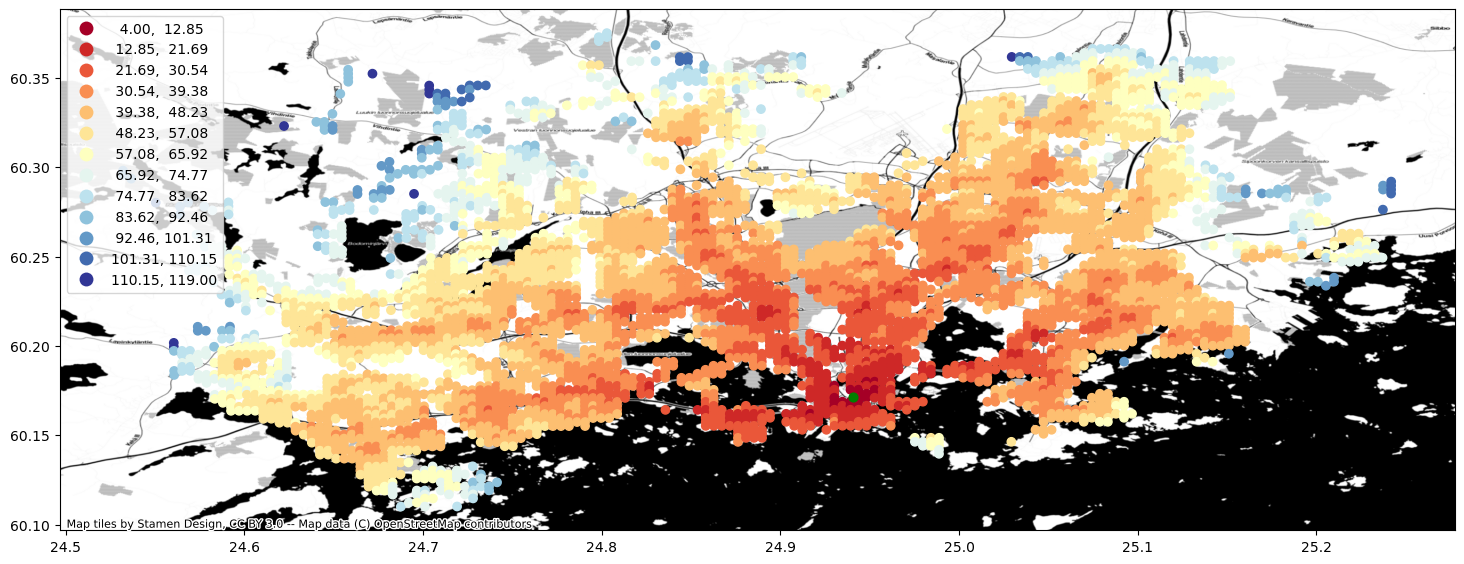

In [16]:
import contextily as cx
ax = geo.plot(column="travel_time", cmap="RdYlBu", scheme="equal_interval", k=13, legend=True, figsize=(18,18))
ax = station.to_crs(crs=geo.crs).plot(ax=ax, color="green", markersize=40)
cx.add_basemap(ax, crs=geo.crs, source=cx.providers.Stamen.Toner)

## Calculate travel times by bike

In a very similar manner, we can calculate travel times by cycling. We only need to modify our `TravelTimeMatrixComputer` object a little bit. We specify the cycling speed by using the parameter `speed_cycling` and we change the `transport_modes` parameter to correspond to `[LegMode.BICYCLE`. This will initialize the object for cycling analyses:

In [17]:
tc_bike = TravelTimeMatrixComputer(
    transport_network,
    origins=station,
    destinations=pop_points,
    speed_cycling=16,
    transport_modes=[LegMode.BICYCLE],
)
ttm_bike = tc_bike.compute_travel_times()

- Let's again make a table join with the population grid

In [18]:
geo = pop_points.merge(ttm_bike, left_on="id", right_on="to_id")

- And plot the data

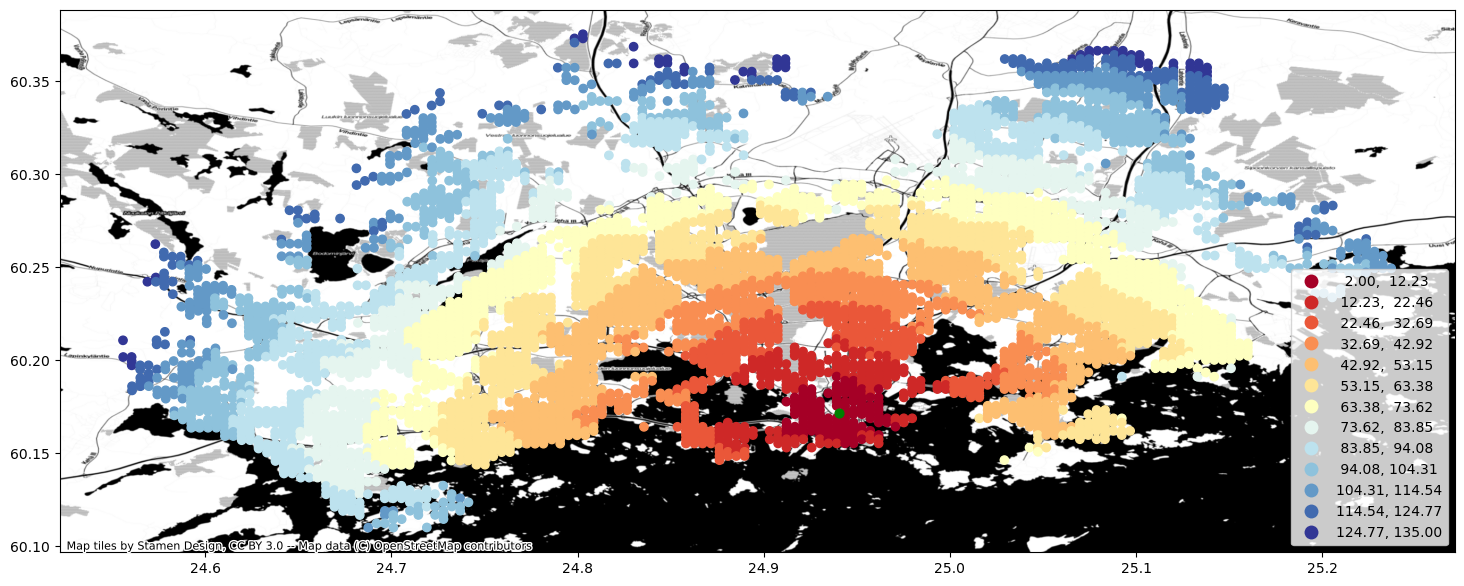

In [19]:
ax = geo.plot(column="travel_time", cmap="RdYlBu", scheme="equal_interval", k=13, legend=True, figsize=(18,18))
ax = station.to_crs(crs=geo.crs).plot(ax=ax, color="green", markersize=40)
cx.add_basemap(ax, crs=geo.crs, source=cx.providers.Stamen.Toner)

## Calculate catchment areas

One quite typical accessibility analysis is to find out catchment areas for multiple locations, such as schools. In the below, we will extract all schools in Helsinki Region and calculate travel times from all grid cells to the closest one. As a result, we have catchment areas for each school.

Let's start by preparing data. In the following, we will:

- Download OSM data about locations of schools in Helsinki area, using `osmnx`. 
- Some of the downloaded geometries might be in Polygon format, so we need to convert them into points by calculating their centroid
- We will also add a column `id` for the data which is required by `r5py` (as well as `r5r`)

In [20]:
import osmnx as ox
from shapely.geometry import box

# Extent of the data for Helsinki Region
# (minx, miny, maxx, maxy)
bounds = pop_points.total_bounds

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=[box(*bounds)], crs="EPSG:4326")

# Download schools from OpenStreetMap
tags = {"amenity": "school"}
schools = ox.geometries_from_polygon(gdf.geometry.values[0], tags)

# Use centroid as geometry (we ignore the shape of the building)
schools["geometry"] = schools.centroid

# Add a unique id column based on the index
schools["id"] = schools.index.droplevel(level=0)

# Plot to map
schools.explore()

/tmp/ipykernel_541463/451468980.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  schools["geometry"] = schools.centroid


- Next, we can initialize our travel time matrix calculator using the schools as the origins:

In [21]:
travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins=schools,
    destinations=pop_points,
    departure=datetime.datetime(2023,1,19,8,30),
    transport_modes=[TransitMode.TRANSIT, LegMode.WALK],
)
travel_time_matrix = travel_time_matrix_computer.compute_travel_times()

In [22]:
travel_time_matrix.shape

(2782818, 3)

- As we can see, there are approx. 2.7 million rows of data, which comes as a result of the connections between origins and destinations. Next, we want aggregate the data and keep only travel time information to the closest school: 

In [23]:
# Find out the travel time to closest school
closest = travel_time_matrix.groupby("to_id")["travel_time"].min().reset_index()

In [25]:
closest.tail()

to_id  travel_time
5829   5829         61.0
5830   5830         60.0
5831   5831         59.0
5832   5832         60.0
5833   5833         63.0

Then we can make a table join with the grid in a similar manner as previously and visualize the data:

In [26]:
geo = pop_points.merge(closest, left_on="id", right_on="to_id")

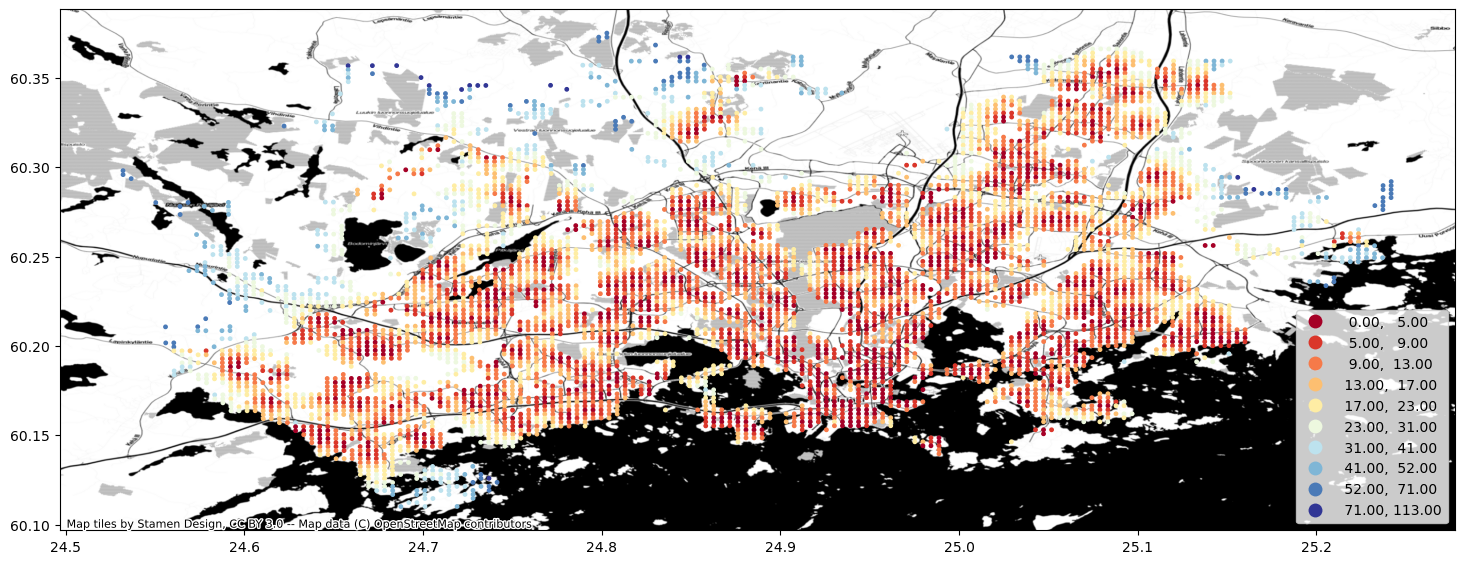

In [30]:
import contextily as cx
ax = geo.plot(column="travel_time", cmap="RdYlBu", scheme="natural_breaks", k=10, legend=True, figsize=(18,18), markersize=6)
cx.add_basemap(ax, crs=geo.crs, source=cx.providers.Stamen.Toner)

In [31]:
# Make an interactive map 
geo.explore(column="travel_time", cmap="RdYlBu", 
            scheme="natural_breaks", k=10, legend=True, 
            marker_kwds={"radius": 2.5})

/home/hentenka/.conda/envs/mamba/envs/sp-test/lib/python3.9/site-packages/geopandas/explore.py:442: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors.to_hex, 1, cm.get_cmap(cmap, k)(binning.yb)
/home/hentenka/.conda/envs/mamba/envs/sp-test/lib/python3.9/site-packages/geopandas/explore.py:624: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors.to_hex, 1, cm.get_cmap(cmap, binning.k)(range(binning.k))


That's it! As you can, see now we have a nice map showing the catchment areas for each school.